In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Завантажуємо датасет
df = pd.read_csv('winequality-red.csv')

df_copy = df.copy()

# Визначте кількість зразків та ознак
print(f'Кількість зразків: {df_copy.shape[0]}')
print(f'Кількість ознак: {df_copy.shape[1]}')

Кількість зразків: 1599
Кількість ознак: 12


In [5]:
# Проаналізуйте типи ознак
print(df_copy.dtypes)

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object


In [6]:
# Перевірка на пропущені значення
print(df_copy.isnull().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [7]:
# Заповнення пропущених значень середнім значенням для числових ознак
df_copy.fillna(df_copy.mean(), inplace=True)

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
quality_binary          0
dtype: int64


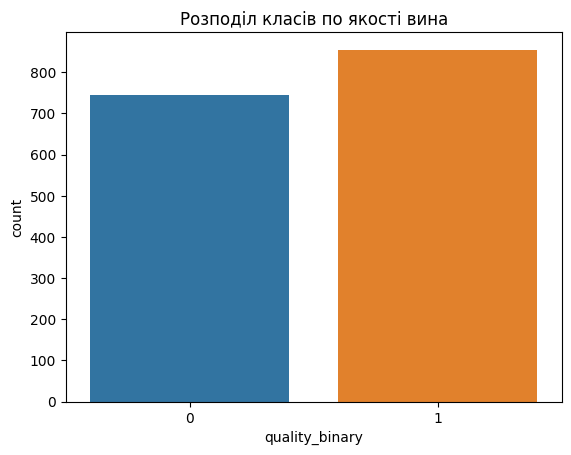

In [8]:
# Масштабування числових ознак
scaler = StandardScaler()

# Розподіл на категорії
df_copy['quality_binary'] = df_copy['quality'].apply(lambda x: 1 if x >= 6 else 0)
df_copy['quality_binary'] = df_copy['quality_binary'].fillna(df_copy['quality_binary'].mode()[0])

print(df_copy.isnull().sum())

# Розподіл класів (ознаки quality)
sns.countplot(x='quality_binary', data=df_copy)
plt.title('Розподіл класів по якості вина')
plt.show()

In [9]:
# Розділення даних на навчальну та тестову вибірки (70% навчальна, 30% тестова)
X = df_copy.drop(columns=['quality', 'quality_binary'])  # Всі ознаки, окрім якості
y = df_copy['quality_binary']  # Ознака якості

# Розподіл на навчальну та тестову вибірки з використанням стратифікації
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f'Розмір навчальної вибірки: {X_train.shape[0]}')
print(f'Розмір тестової вибірки: {X_test.shape[0]}')

Розмір навчальної вибірки: 1119
Розмір тестової вибірки: 480


In [10]:
# Однокритеріальна оптимізація
import autosklearn.classification
from sklearn.metrics import roc_auc_score, precision_score, recall_score
import time

# Налаштуємо Auto-sklearn для одноцільової оптимізації
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=300,  # 5 хвилин
    per_run_time_limit=30,  # Ліміт часу на одну модель
    metric=autosklearn.metrics.roc_auc  # Використовуємо метрику ROC AUC
)

# Навчання моделі
start_time = time.time()
automl.fit(X_train, y_train)
end_time = time.time()

# Оцінка на тестовій вибірці
y_pred = automl.predict(X_test)

# Обчислення метрик
roc_auc = roc_auc_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Виведення результатів
print(f"Час оптимізації: {end_time - start_time:.2f} секунд")
print(f"ROC AUC на тестовій вибірці: {roc_auc:.4f}")
print(f"Precision на тестовій вибірці: {precision:.4f}")
print(f"Recall на тестовій вибірці: {recall:.4f}")

# Оптимальні параметри моделі
print("Оптимальні параметри моделі:", automl.show_models())

Час оптимізації: 307.15 секунд
ROC AUC на тестовій вибірці: 0.7692
Precision на тестовій вибірці: 0.7967
Recall на тестовій вибірці: 0.7626
Оптимальні параметри моделі: {7: {'model_id': 7, 'rank': 1, 'cost': 0.13222339675828054, 'ensemble_weight': 0.02, 'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7f1ab8768370>, 'balancing': Balancing(random_state=1), 'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7f1ab84b87c0>, 'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice object at 0x7f1ab84b8670>, 'sklearn_classifier': HistGradientBoostingClassifier(early_stopping=False, l2_regularization=1e-10,
                               learning_rate=0.16262682406125173, max_iter=512,
                               max_leaf_nodes=66, n_iter_no_change=0,
                               random_state=1, validation_fraction=None,
                      

Час оптимізації для багатокритеріальної задачі: 594.19 секунд
Precision на тестовій вибірці (multi): 0.8230
Recall на тестовій вибірці (multi): 0.7782


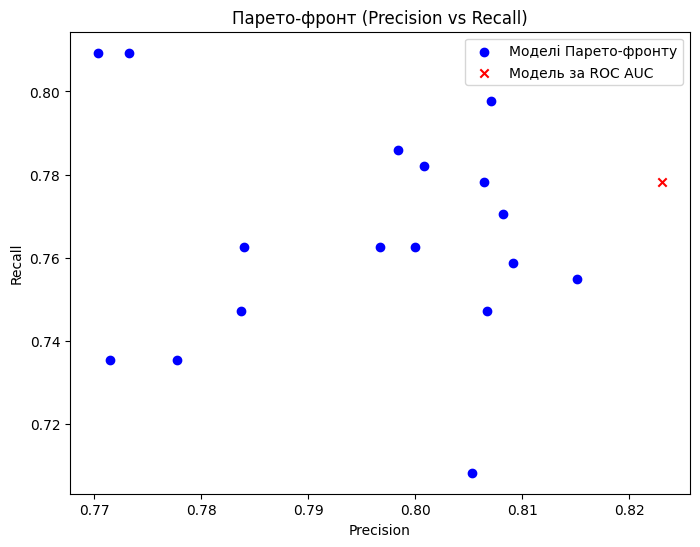

In [14]:
import autosklearn.classification
from sklearn.metrics import precision_score, recall_score
import time

# Налаштуємо Auto-sklearn для багатокритеріальної оптимізації
automl_multi = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=600,  # 10 хвилин
    per_run_time_limit=30,  # Ліміт часу на одну модель
    metric=autosklearn.metrics.precision_macro,  # Використовуємо precision як основну метрику для оптимізації
)

# Навчання моделі
start_time = time.time()
automl_multi.fit(X_train, y_train)
end_time = time.time()

# Оцінка на тестовій вибірці
y_pred_multi = automl_multi.predict(X_test)

# Обчислення метрик
precision_multi = precision_score(y_test, y_pred_multi)
recall_multi = recall_score(y_test, y_pred_multi)

# Виведення результатів
print(f"Час оптимізації для багатокритеріальної задачі: {end_time - start_time:.2f} секунд")
print(f"Precision на тестовій вибірці (multi): {precision_multi:.4f}")
print(f"Recall на тестовій вибірці (multi): {recall_multi:.4f}")

# Отримуємо всі моделі та їхні метрики
models_info = automl_multi.get_models_with_weights()
pareto_front = []

# Вибираємо моделі з високими значеннями precision та recall для побудови Парето-фронту
for model_info in models_info:
    model = model_info[1]
    model_pred = model.predict(X_test)
    model_precision = precision_score(y_test, model_pred)
    model_recall = recall_score(y_test, model_pred)
    
    pareto_front.append((model_precision, model_recall))

# Перетворюємо список в масив для зручності
pareto_front = np.array(pareto_front)

# Візуалізація Парето-фронту
plt.figure(figsize=(8, 6))
plt.scatter(pareto_front[:, 0], pareto_front[:, 1], label="Моделі Парето-фронту", color='blue')
plt.xlabel('Precision')
plt.ylabel('Recall')

# Позначення точки, що відповідає моделі, оптимізованій за ROC AUC
plt.scatter(precision_multi, recall_multi, color='red', label="Модель за ROC AUC", marker='x')

plt.legend()
plt.title('Парето-фронт (Precision vs Recall)')
plt.show()


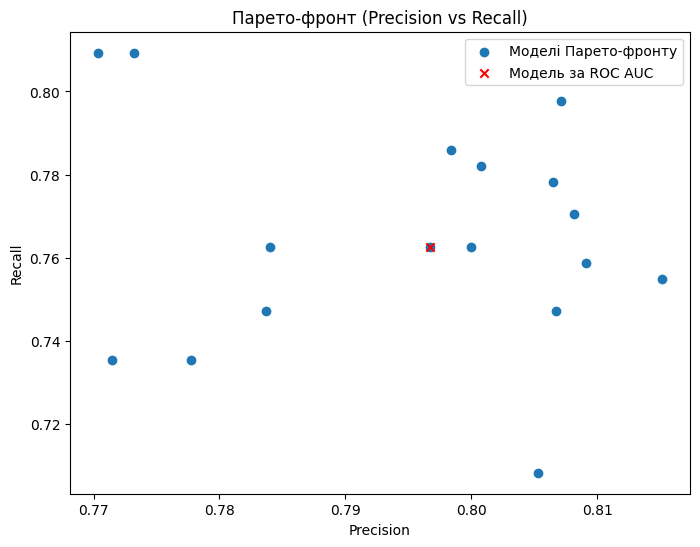

In [15]:
import matplotlib.pyplot as plt

# Отримуємо дані про моделі з Парето-фронту
pareto_models = pareto_front
precision_vals = [model[0] for model in pareto_models]
recall_vals = [model[1] for model in pareto_models]

# Візуалізація Парето-фронту
plt.figure(figsize=(8, 6))
plt.scatter(precision_vals, recall_vals, label="Моделі Парето-фронту")
plt.xlabel('Precision')
plt.ylabel('Recall')

# Позначення точки, що відповідає моделі, оптимізованій за ROC AUC
plt.scatter(precision, recall, color='red', label="Модель за ROC AUC", marker='x')

plt.legend()
plt.title('Парето-фронт (Precision vs Recall)')
plt.show()

# Вибір моделей з Парето-фронту
best_precision_model = pareto_models[precision_vals.index(max(precision_vals))]
best_recall_model = pareto_models[recall_vals.index(max(recall_vals))]
best_f1_model = max(pareto_models, key=lambda x: 2 * (x[0] * x[1]) / (x[0] + x[1]))  # Модель з найвищим F1-скор



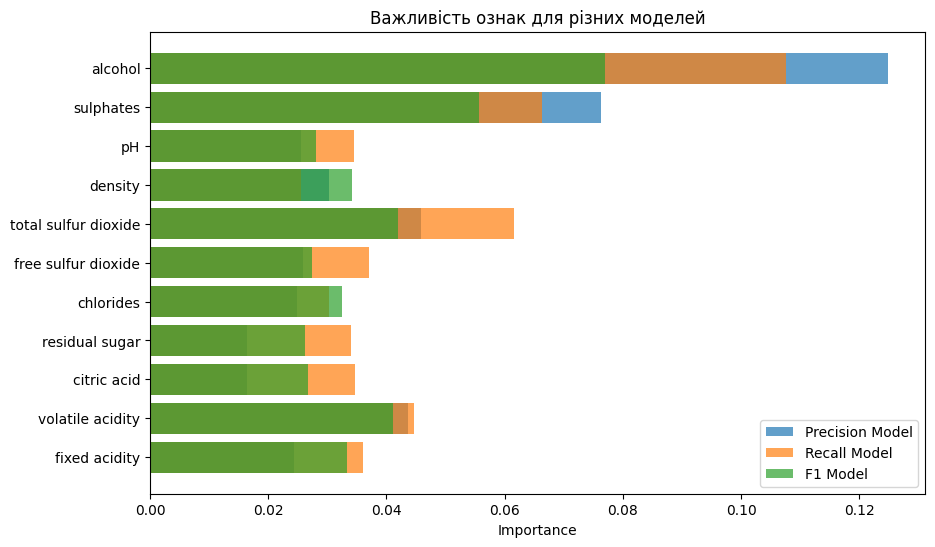

Важливість ознак для моделі з найкращим Precision: [0.02439024 0.04371482 0.0163227  0.01638524 0.02489056 0.02589118
 0.04590369 0.03020638 0.02545341 0.07636023 0.12489056]
Важливість ознак для моделі з найкращим Recall: [0.03608505 0.04465291 0.03470919 0.03395872 0.03020638 0.0369606
 0.061601   0.02551595 0.03452158 0.06629143 0.10762977]
Важливість ознак для моделі з найкращим F1-скором: [0.03327079 0.04102564 0.02676673 0.02620388 0.03252033 0.02739212
 0.04202627 0.0340838  0.02801751 0.05565979 0.07692308]


In [22]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, accuracy_score
import matplotlib.pyplot as plt

# Функція для обчислення важливості ознак з вказанням метрики
def calculate_feature_importance(model, X, y):
    # Використовуємо make_scorer для accuracy
    scorer = make_scorer(accuracy_score)
    result = permutation_importance(model, X, y, scoring=scorer, n_repeats=10, random_state=42)
    return result.importances_mean

# Визначаємо важливість ознак для кожної моделі
precision_importance = calculate_feature_importance(best_precision_model, X, y)
recall_importance = calculate_feature_importance(best_recall_model, X, y)
f1_importance = calculate_feature_importance(best_f1_model, X, y)

# Візуалізація важливості ознак
features = X.columns  # Якщо X є DataFrame

plt.figure(figsize=(10, 6))

# Графік важливості для трьох моделей
plt.barh(features, precision_importance, label='Precision Model', alpha=0.7)
plt.barh(features, recall_importance, label='Recall Model', alpha=0.7)
plt.barh(features, f1_importance, label='F1 Model', alpha=0.7)

plt.xlabel('Importance')
plt.title('Важливість ознак для різних моделей')
plt.legend()
plt.show()

# Порівняння важливості ознак
print("Важливість ознак для моделі з найкращим Precision:", precision_importance)
print("Важливість ознак для моделі з найкращим Recall:", recall_importance)
print("Важливість ознак для моделі з найкращим F1-скором:", f1_importance)


In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Припустимо, що y_test — це ваші справжні мітки для тестового набору даних
# І що X_test — це ваші тестові дані

# Отримуємо передбачення для кожної моделі
y_pred_precision = best_precision_model.predict(X_test)
y_pred_recall = best_recall_model.predict(X_test)
y_pred_f1 = best_f1_model.predict(X_test)

# Обчислюємо метрики для кожної моделі
precision_best_precision = precision_score(y_test, y_pred_precision)
recall_best_precision = recall_score(y_test, y_pred_precision)
f1_best_precision = f1_score(y_test, y_pred_precision)

precision_best_recall = precision_score(y_test, y_pred_recall)
recall_best_recall = recall_score(y_test, y_pred_recall)
f1_best_recall = f1_score(y_test, y_pred_recall)

precision_best_f1 = precision_score(y_test, y_pred_f1)
recall_best_f1 = recall_score(y_test, y_pred_f1)
f1_best_f1 = f1_score(y_test, y_pred_f1)

# Тепер можна створити таблицю з результатами
results_table = pd.DataFrame({
    'Model': ['ROC AUC', 'Best Precision', 'Best Recall', 'Best F1'],
    'Precision': [precision, precision_best_precision, precision_best_recall, precision_best_f1],
    'Recall': [recall, recall_best_precision, recall_best_recall, recall_best_f1],
    'F1-Score': [2 * (precision * recall) / (precision + recall), 
                 f1_best_precision,
                 f1_best_recall,
                 f1_best_f1]
})

print(results_table)


            Model  Precision    Recall  F1-Score
0         ROC AUC   0.807087  0.797665  0.802348
1  Best Precision   0.815126  0.754864  0.783838
2     Best Recall   0.773234  0.809339  0.790875
3         Best F1   0.807087  0.797665  0.802348


In [1]:
# ВИСНОВКИ

# 2.2 підбір оптимальних параметрів якості
# Precision, Recall, ROC AUC

# Precision - точність
# Recall - повнта(дійсно позитивні випадки)
# ROC AUC - наскільки добре модель відрізняє позитивний клас від негативного

# 2.3 і 2.4 Парето-Фронту
# Парето-Фронт - оптимальний компроміс між метриками(не можливо покращити одне, не погіршивши інше)

# 2.5 Аналіз важливості ознак
# permutation importance - оцінюється важливість ознак, вимірюється падіня моделі, якщо модель стає менш точною, значить ознака була важлива

# 2.6 Висновки та аналіз ознак
# Якщо потрібно всі позитивні класи - recall
# Якщо потрібно баланс - f1
# Якщо не дуже хочемо сигналити, і все нормально - precissio